In [1]:
import pandas
import numpy
from matplotlib import pyplot as plt
from toposample.data.data_structures import ConditionCollection

%matplotlib inline

# Parameters defining tolerance thresholds
outlier_upper_thresh = 2.0
outlier_lower_thresh = 1.0 / outlier_upper_thresh

# Load data and instantiate useful data structures
fn = "/home/reimann/Documents/data/THNCX/M7_validation/compared_densities_VIP_SST_PV_06_17_21.pkl"
data = pandas.read_pickle(fn)
densities = ConditionCollection.from_pandas(data["Density"])
volumes = ConditionCollection.from_pandas(data["Volume"])

# Get lists of layers, mtypes and regions parameterized in the data
layers = sorted(densities.labels_of("Layer"))
mtypes = sorted(densities.labels_of("Mtype"))
regions = densities.labels_of("Region")

# Volume of an area is independent of m-type (i.e. all values identical for the various mtypes.).
# For simplicity, filter for only values associated with one region.
volumes = volumes.filter(Mtype=mtypes[0])
# After that filtering, we can remove that now reundant condition.
volumes = volumes.remove_label("Mtype")

In [2]:
def filter_layer(layers, mtypes, regions, values):
    for l, m, r, v in zip(layers, mtypes, regions, values):
        if "_" in m:
            splt = m.split("_")[0]
            if l not in splt:
                v = numpy.NaN
        yield v, {"Layer": l, "Mtype": m, "Region": r}

def ordered_stack(x, y):
    idxx = numpy.argsort(x)
    return [y[i] for i in idxx]

# densities = densities.transform(["Layer", "Mtype", "Region"], func=filter_layer, xy=True)
dens_vecs = densities.pool(["Region"], func=ordered_stack, xy=True)
vol_vecs = volumes.pool(["Region"], func=ordered_stack, xy=True)


<ipython-input-3-4bf377bd184c>:27: RuntimeWarning: invalid value encountered in true_divide
  for reg, adj in zip(regions, fix_dens / vec_dens):
<ipython-input-3-4bf377bd184c>:27: RuntimeWarning: divide by zero encountered in true_divide
  for reg, adj in zip(regions, fix_dens / vec_dens):
<ipython-input-3-4bf377bd184c>:27: RuntimeWarning: divide by zero encountered in true_divide
  for reg, adj in zip(regions, fix_dens / vec_dens):
<ipython-input-3-4bf377bd184c>:27: RuntimeWarning: divide by zero encountered in true_divide
  for reg, adj in zip(regions, fix_dens / vec_dens):
<ipython-input-3-4bf377bd184c>:2: RuntimeWarning: Mean of empty slice
  mean_dens = numpy.nanmean(vec_dens)
<ipython-input-3-4bf377bd184c>:16: RuntimeWarning: invalid value encountered in double_scalars
  densities_out = numpy.array(densities_out) + (bank / numpy.nansum(vec_vol))
<ipython-input-3-4bf377bd184c>:2: RuntimeWarning: Mean of empty slice
  mean_dens = numpy.nanmean(vec_dens)
<ipython-input-3-4bf377bd184

<ipython-input-3-4bf377bd184c>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax = plt.figure(figsize=(8, 3)).gca()
<ipython-input-3-4bf377bd184c>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax = plt.figure(figsize=(8, 3)).gca()
<ipython-input-3-4bf377bd184c>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax = p

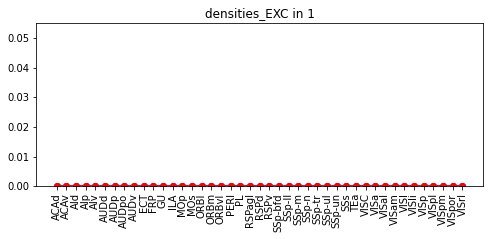

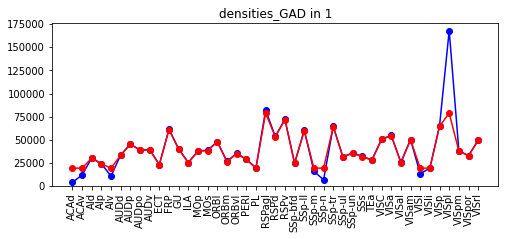

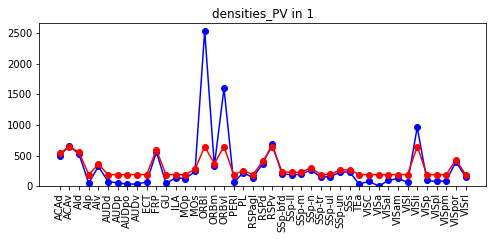

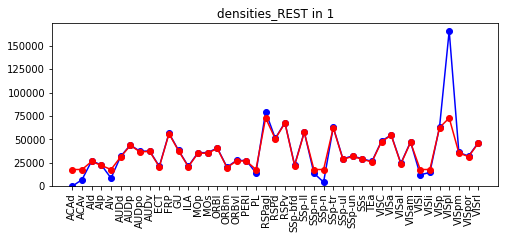

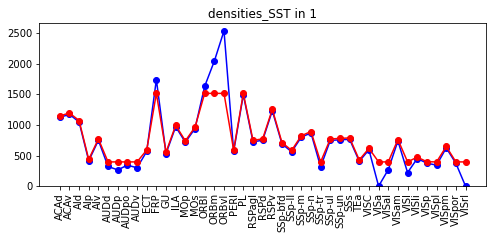

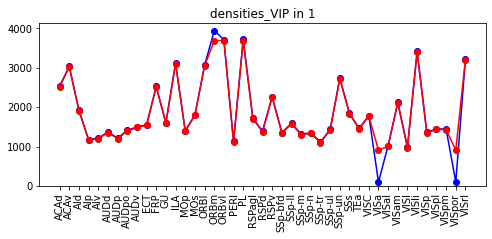

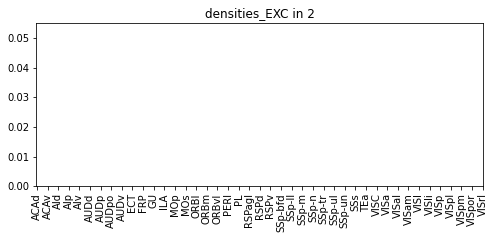

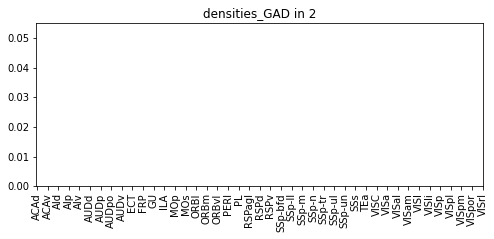

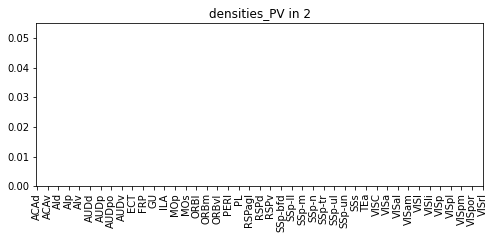

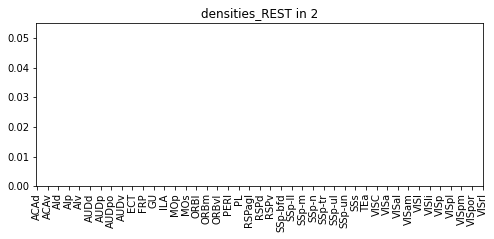

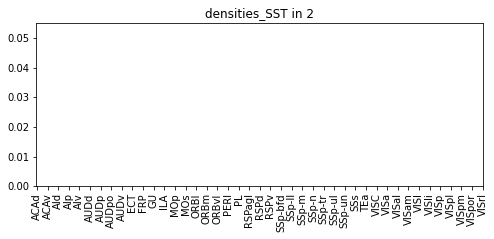

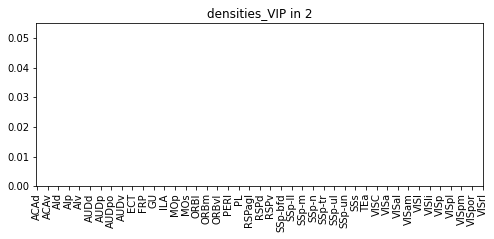

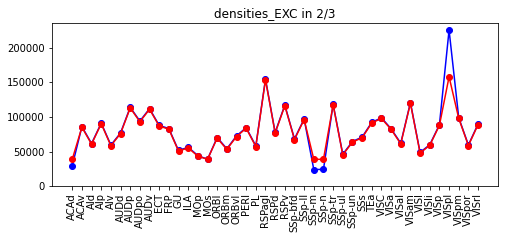

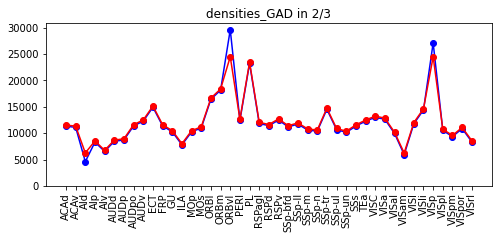

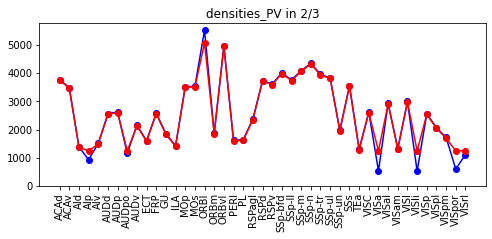

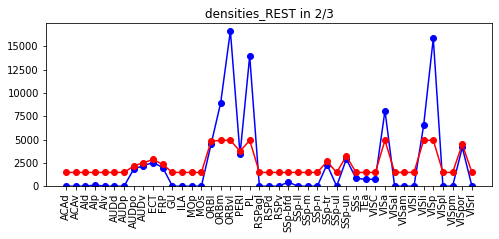

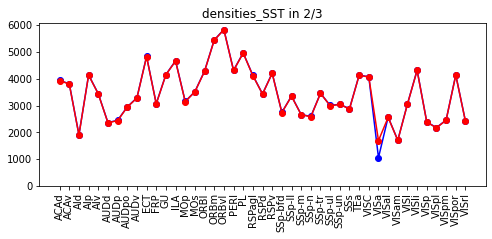

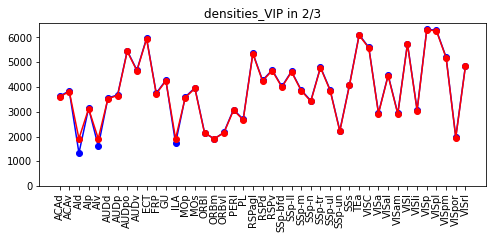

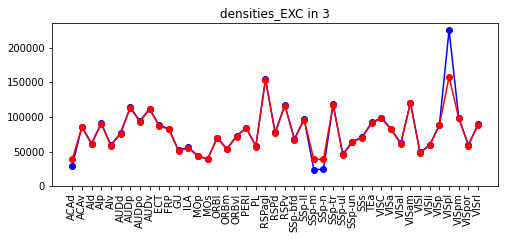

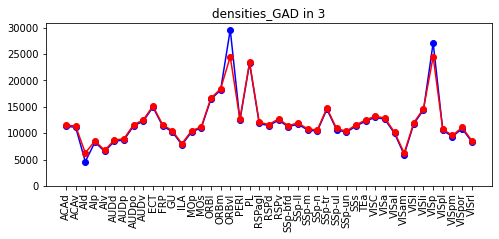

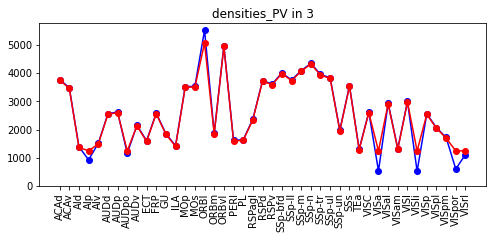

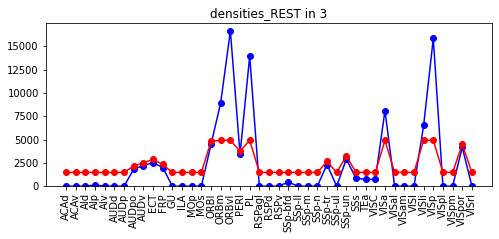

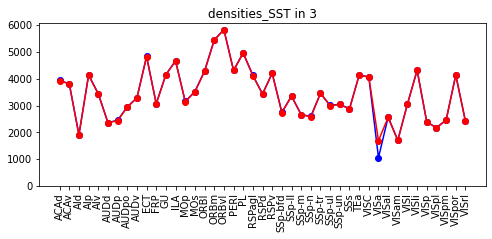

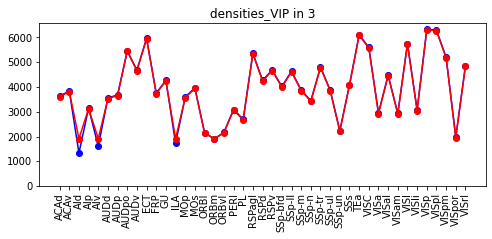

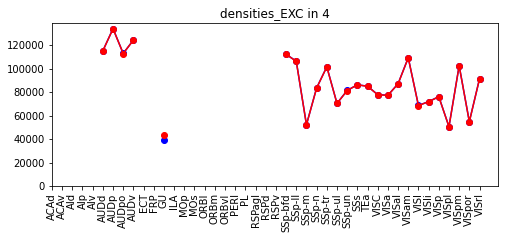

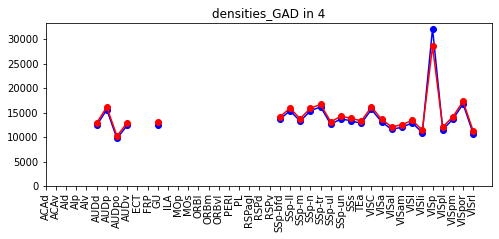

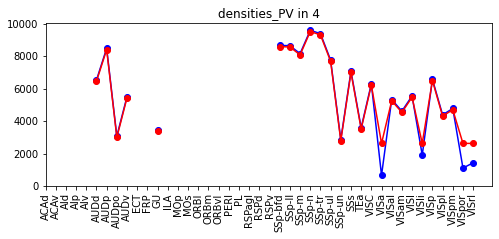

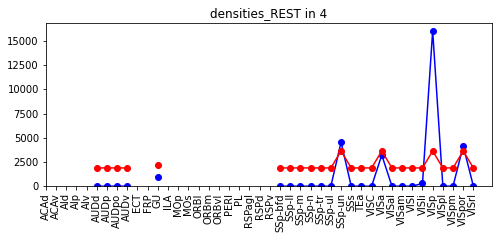

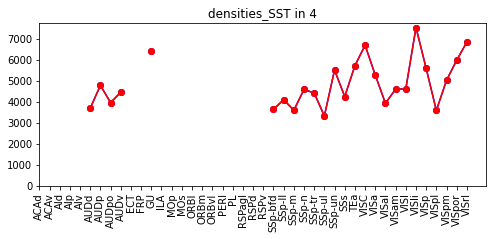

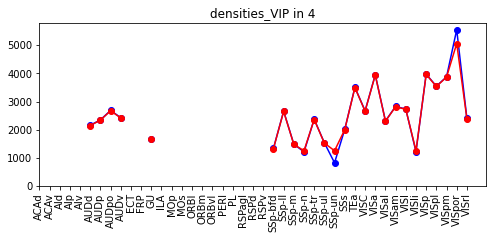

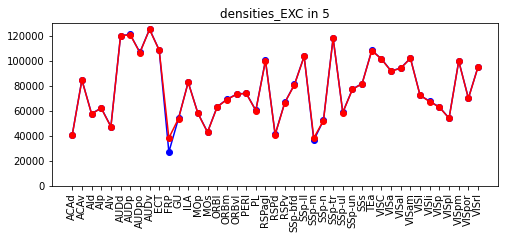

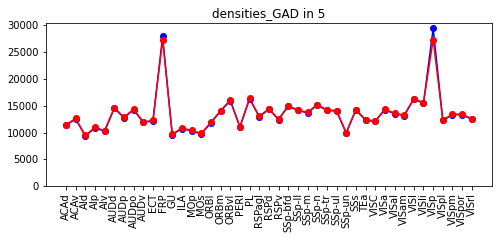

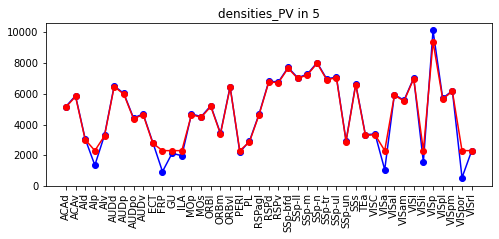

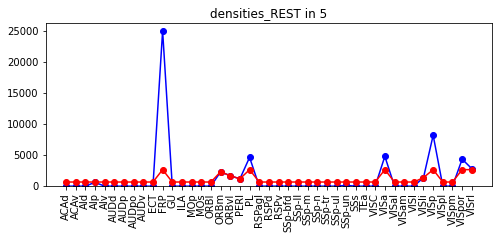

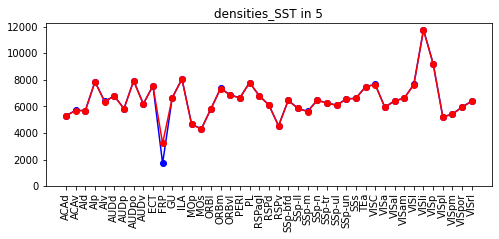

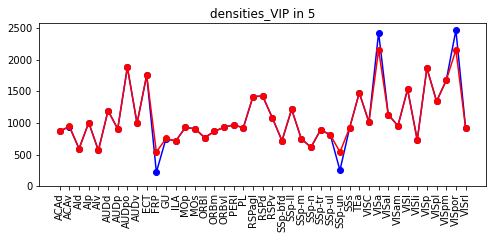

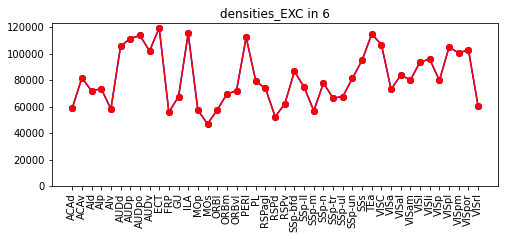

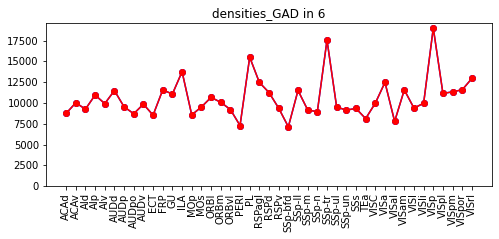

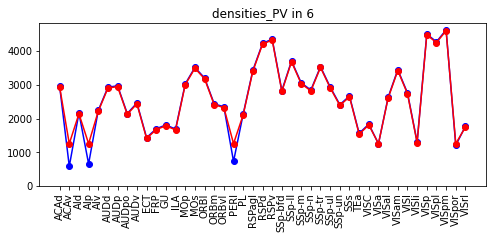

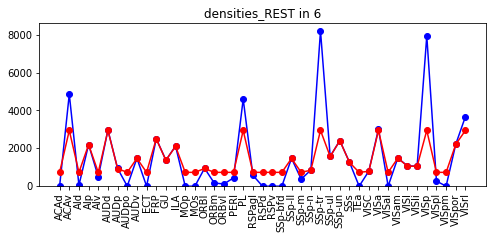

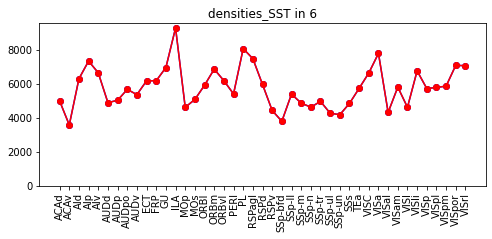

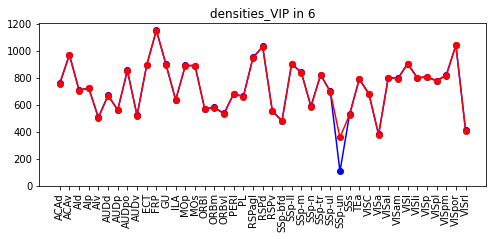

In [3]:
def redistribute_density(vec_dens, vec_vol):
    mean_dens = numpy.nanmean(vec_dens)
    tol_max = outlier_upper_thresh * mean_dens
    tol_min = outlier_lower_thresh * mean_dens
    bank = 0.0
    densities_out = []
    for d, v in zip(vec_dens, vec_vol):
        if d > tol_max:
            densities_out.append(tol_max)
        elif d < tol_min:
            densities_out.append(tol_min)
        else:
            densities_out.append(d)
        if not numpy.isnan(d):
            bank += (d - densities_out[-1]) * v
    densities_out = numpy.array(densities_out) + (bank / numpy.nansum(vec_vol))
    return densities_out

adjustment_dict = {}
for layer in layers:
    for mtype in mtypes:
        ax = plt.figure(figsize=(8, 3)).gca()
        vec_dens = dens_vecs.get2(Layer=layer, Mtype=mtype)
        vec_vol = vol_vecs.get2(Layer=layer)
        ax.plot(range(len(vec_dens)), vec_dens, marker='o', color='blue')
        fix_dens = redistribute_density(vec_dens, vec_vol)
        for reg, adj in zip(regions, fix_dens / vec_dens):
            if not numpy.isnan(adj):
                adjustment_dict[(mtype, reg, layer)] = adj
        ax.plot(range(len(fix_dens)), fix_dens, marker='o', color='red')
        ylim = ax.get_ylim()
        ax.set_ylim([0, ylim[1]])
        ax.set_xticks(range(len(regions)))
        ax.set_title("{0} in {1}".format(mtype, layer))
        _ = ax.set_xticklabels(regions, rotation="vertical")

In [4]:
fn_for_adjustments = "/home/reimann/Documents/data/THNCX/M7_validation/density_adjustments_VIP_SST_PV_06_17_21.pkl"
k, v = zip(*adjustment_dict.items())
idx = pandas.MultiIndex.from_tuples(list(k), names=["mtype", "region", "layer"])
pandas.Series(list(v), index=idx).to_pickle(fn_for_adjustments)